# Regularization (L2)


- **Data**: a generated dataset
- **Model**: a linear model with polynomial features and L2 regularization
- **Cost**:  MSE loss and regularization penalty

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng

%matplotlib inline
plt.rcParams["figure.figsize"] = (7, 5)


# The Data
We use a **polynomial model of Degree D** to **generate** the dataset.

$$
y = \sum_{d=0}^{D} \beta_d \cdot x^d
$$


In [2]:
# order of the polynomial used to GENERATE the data
poly_order_GEN = 7


In [3]:
# define a helper function to plot the models predictions
def plot_poly(coeffs, x_range):
    x = np.linspace(x_range[0], x_range[1], 50)
    y = np.polyval(coeffs, x)
    plt.plot(x, y, '-', linewidth=3, color='gray', label='unknow function')
    plt.xlabel('x')
    plt.ylabel('y=f(x)')
    plt.grid()


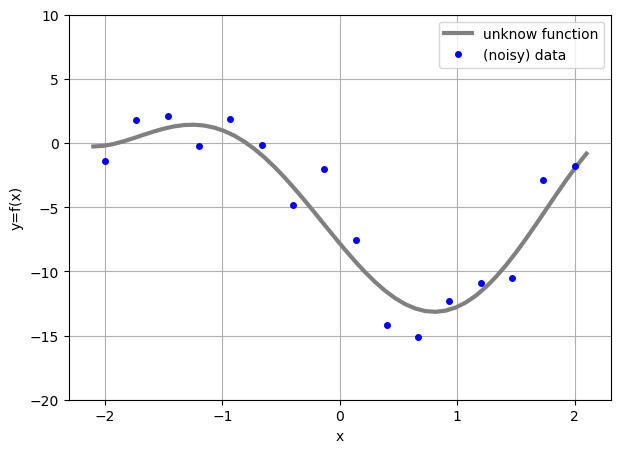

In [5]:

# generate the dataset

nr_of_data_points = 16
noise_scale_factor = 0.15  # make the noise level relative to min/max Y-values.

# define intervals for simple data generation and visualization
interval_data = [-2, 2]  # restrict the domain where we sample points
interval_plot_x = [-2.1, 2.1]  # plot interval of x axis
interval_plot_y = [-20, 10]  # plot interval of y axis
# allowing roots outside the plot interval gives more interesting polynomials.
interval_roots = [-5, 5]

# generate random coefficients. Note: we could generate the coefficients directly from a random generator,
# but it gives nicer plots if we generate roots at random locations and then calculate the coefficients from there.
# setting a seed make the sequence of pseudo-random numbers reproducible
rng = default_rng(seed=19)
roots = rng.uniform(interval_roots[0], interval_roots[1], poly_order_GEN)
# avoid huge values. Scale coeffs down by 0.02
coefficients = np.poly(roots) * 0.02

# reshaping transfroms the data from a n-dim-vector into an n-by-1 matrix
X_Data = np.linspace(
    interval_data[0], interval_data[1], nr_of_data_points).reshape(-1, 1)
Y_no_noise = np.polyval(coefficients, X_Data)
range_y = np.max(Y_no_noise) - np.min(Y_no_noise)
noise = rng.normal(loc=0.0, scale=range_y *
                   noise_scale_factor, size=Y_no_noise.shape)
Y_Data = Y_no_noise + noise


plot_poly(coefficients, interval_plot_x)
plt.plot(X_Data, Y_Data, 'o', color='blue', markersize=4, label='(noisy) data')
plt.ylim(interval_plot_y)
plt.legend()


# The model
- Preprocessing
- Fitting

### Feature Engineering
Because we want to use a linear model to fit data that is not linear, we need to extend the feature space.
We can do this by adding higher order polynomial terms to the feature vector.
For example, in this 1D case, we can add a second feature that is the square of the original feature.
This will allow us to fit a quadratic function to the data.

### Scaling
It is important to scale the polynomial features.   
Otherwise higher order polynomial features can become very large.   
 $x = 5   $  →  $   x^{16} = 152587890625$

In [6]:
# the order of the polynomial used to FIT the data (complexity of the model)
poly_order_MODEL = 16


In [7]:
# use sklearn to build a preprocessing pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline


# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
# creates a array of powers of the input features up to the specified degree
# e.g. for degree=6: [x] -> [x, x^2, x^3, x^4, x^5, x^6]
poly_ftr = PolynomialFeatures(poly_order_MODEL, include_bias=False)

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
scaler = StandardScaler()


## Define a linear model using scikit-learn
We use a linear model with ridge regularization   
https://scikit-learn.org/stable/modules/linear_model.html  
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge


In [8]:
import sklearn
from sklearn import linear_model
from sklearn import metrics

# defining the model
# we use a linear_regression model with L2-Norm regularization
l2_lambda = 0.0000001  # regularization parameter
model = linear_model.Ridge(alpha=l2_lambda)


## Sklearn Pipeline
To combine the preprocessing steps and the model into a single object, we use [sklearn's Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) class

In [9]:
model_pipe = Pipeline([
    ("poly_ftr", poly_ftr),
    ("scaler", scaler),
    ("model", model)
])

In [10]:
# define a helper function to plot the models predictions
def plot_model(model_pipe, x_range):
    x = np.linspace(x_range[0], x_range[1], 50).reshape(-1, 1)
    y = model_pipe.predict(x)
    plt.plot(x, y, '-', linewidth=1, color='red', label='model output')
    plt.xlabel('x')
    plt.ylabel('y=f(x)')
    plt.grid()


## Fit the model on the data

In [13]:
# fitting the pipeline to the data
model_pipe.fit(X_Data, Y_Data)

# make a prediction
Y_hat = model_pipe.predict(X_Data)

# evaluate the model
mse = metrics.mean_squared_error(Y_Data, Y_hat)

print(f"Mean squared error: {mse:.2f}")

Mean squared error: 0.39


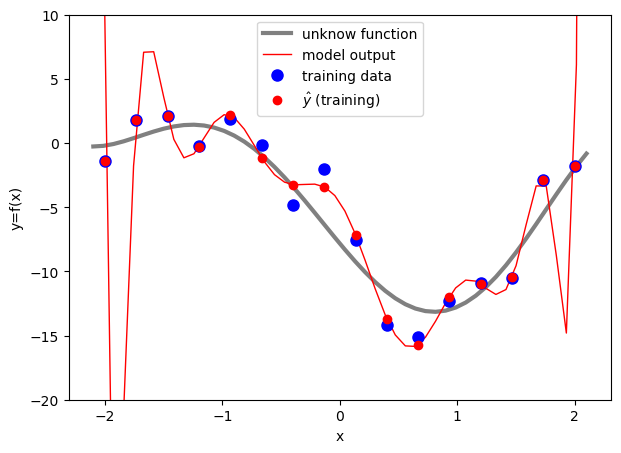

In [14]:
# Plot the model output and the data
plot_poly(coefficients, interval_plot_x)
plot_model(model_pipe, interval_plot_x)
plt.plot(X_Data, Y_Data, 'o', color='blue',
         markersize=8, label='training data')
plt.plot(X_Data, Y_hat, 'or', markersize=6, label='$\hat{y}$ (training)')
plt.ylim(interval_plot_y)
plt.legend()


In [15]:
# we can access the weights of the fitted model
display(model.coef_)  # printing the weights of the model
display(model.intercept_)  # printing the intercept of the model


array([[  -17.34935887,   -50.84651121,    22.68122183,   539.18241001,
           23.51671229, -1919.65014895,    62.7346686 ,  2493.37660914,
         -469.220047  ,  -131.32447339,   326.82887264, -1287.7284929 ,
          463.28224512,  -541.03030955,  -415.91950527,   899.81375989]])

array([-4.87104422])

The regularization parameter above lead to overfitting. You are asked to find a suitable value of lambda.

When evaluating a model, it is important to use a test set that is not used during training! 

- Implement a function that returns a train/test split of the data given to it.
- Train abobe pipeline on the training set and evaluate it o

To make it loosely compatible with the sklearn implementation, make sure the function can be used as follows:  
`X_train, X_test, Y_train, Y_test = split_train_test(X_Data, Y_Data, split_ratio=0.2)`



Mean squared error on training data: 0.11
Mean squared error on test data: 5.39


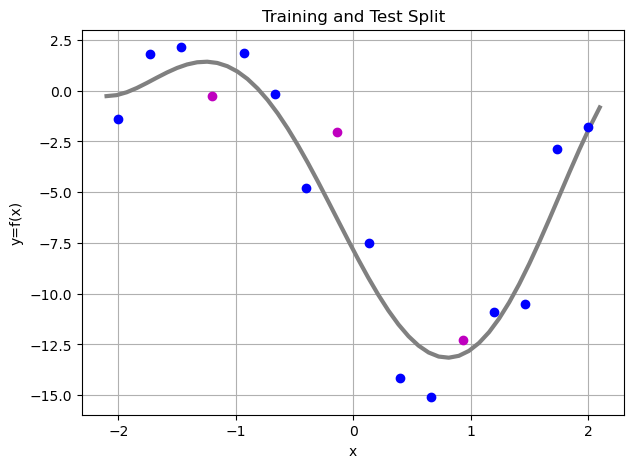

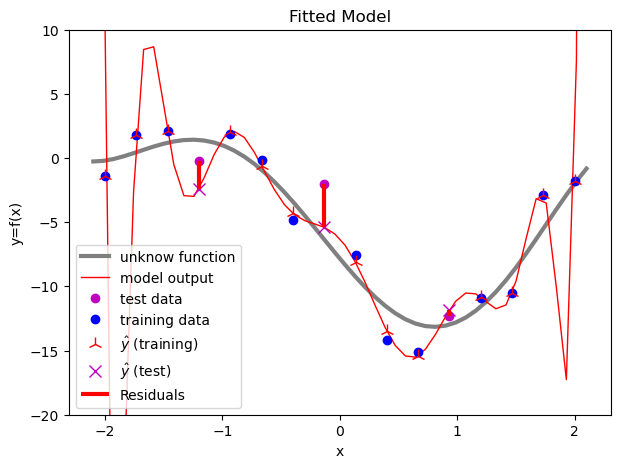

In [16]:
def split_train_test(X, Y, split_ratio=0.2):
    # Splitting the data inte test and training set
    # It is important, that the data is shuffled before the splitting
    # Here it is implemented using indexing with permutation
    n_samples = X.shape[0]
    test_size = int(n_samples * split_ratio)
    rng = np.random.default_rng(seed=5)
    idx = rng.permutation(n_samples)
    train_idx, test_idx = idx[test_size:], idx[:test_size]
    X_train, X_test = X[train_idx,:], X[test_idx,:]
    Y_train, Y_test = Y[train_idx,:], Y[test_idx,:]
    return X_train, X_test, Y_train, Y_test     


X_train, X_test, Y_train, Y_test = split_train_test(X_Data, Y_Data, split_ratio=0.2)

# Plot the split data to see if it is reasonable
plt.figure()
plot_poly(coefficients, interval_plot_x)
plt.plot(X_test, Y_test, 'om', markersize=6, label='test data')
plt.plot(X_train, Y_train,'o', color='blue', markersize=6, label='training data')
plt.title('Training and Test Split')


model_pipe.fit(X_train, Y_train)

y_hat_train = model_pipe.predict(X_train)
y_hat_test = model_pipe.predict(X_test)

# calculate the MSE
mse_train = metrics.mean_squared_error(Y_train, y_hat_train)
mse_test = metrics.mean_squared_error(Y_test, y_hat_test)

print(f"Mean squared error on training data: {mse_train:.2f}")
print(f"Mean squared error on test data: {mse_test:.2f}")


# Plotting the Result
plt.figure()
plot_poly(coefficients, interval_plot_x)
plot_model(model_pipe, interval_plot_x)
plt.plot(X_test, Y_test, 'om', markersize=6, label='test data')
plt.plot(X_train, Y_train, 'o', color='blue',
            markersize=6, label='training data')
plt.plot(X_train, y_hat_train, '2r', markersize=10,
            label='$\hat{y}$ (training)')
plt.plot(X_test, y_hat_test, 'xm', markersize=8,
            label='$\hat{y}$ (test)')
# we can add the residuals by plotting vertical lines at the specified locations:
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.vlines.html
plt.vlines(X_test, Y_test, y_hat_test, colors='r',
            linewidth=3, label='Residuals')
plt.ylim(interval_plot_y)
plt.title(f'Fitted Model')
plt.legend()

###

- Split the data into training and test samples. If you implemented a split_train_test function in Exercise 2, use it.    
Otherwise, use Sklearn's implementation of [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

- For multiple values of lambda for Ridge regression, fit a pipeline on the training data. Evaluate and store the mse on the train and test split for each lambda. 
 
- Plot the train and test mse for the different values of lambda you stored in the previous step.
    - Hint: When plotting the mse for lamdas that are not spaced evenly, you can stretch the plot to display all values with equal spacing using `plt.xticks(np.arange(len(l2_lambdas)), l2_lambdas)`
    - Hint: When your selection of lamdas did not yield a clear result, try the following lambdas: `[0.0, 0.00001, 0.0005, 0.001, 0.005, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 30.0]`  

c:\Users\mrcls\.conda\envs\AIFO23\lib\site-packages\sklearn\linear_model\_ridge.py:250: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


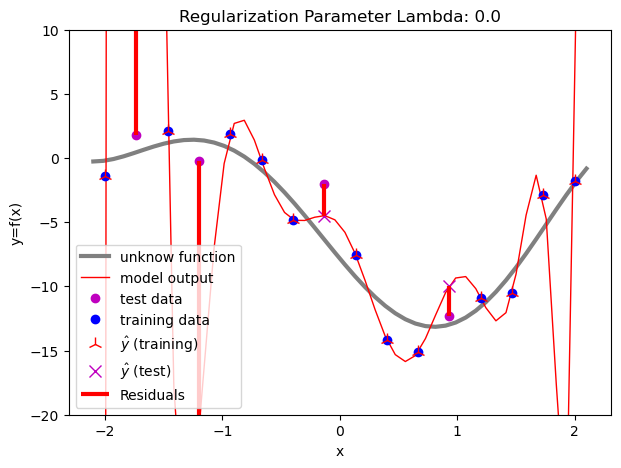

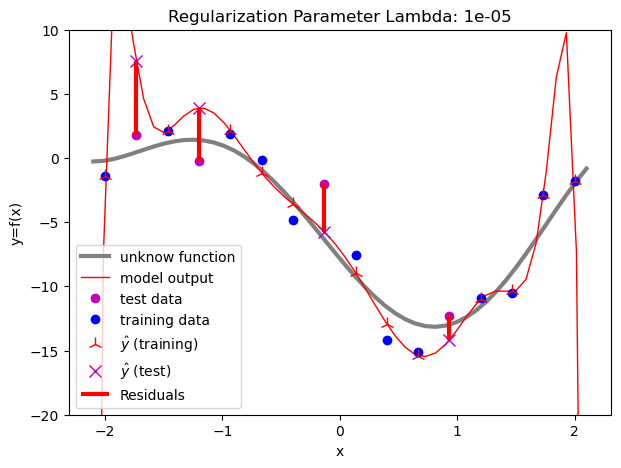

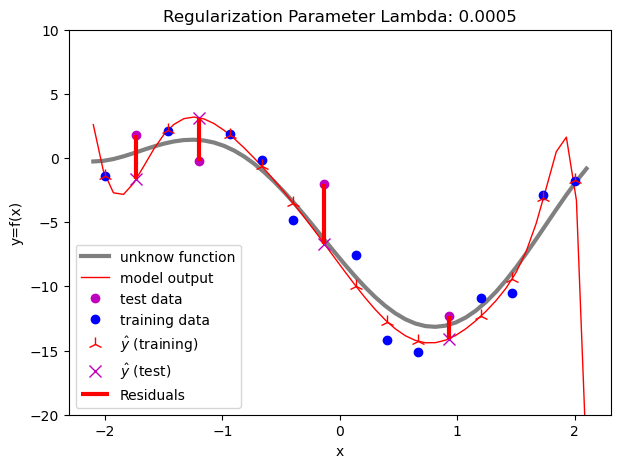

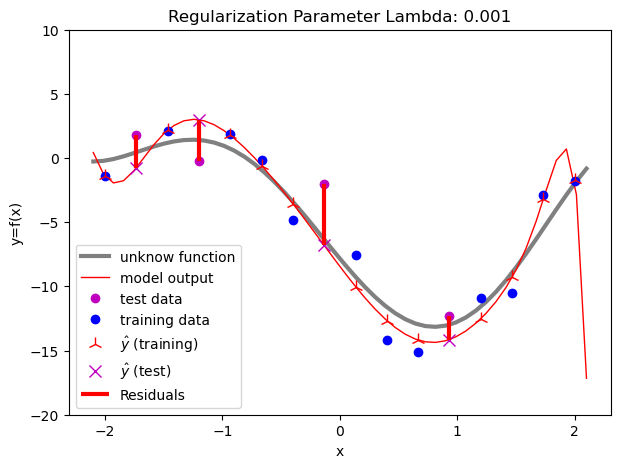

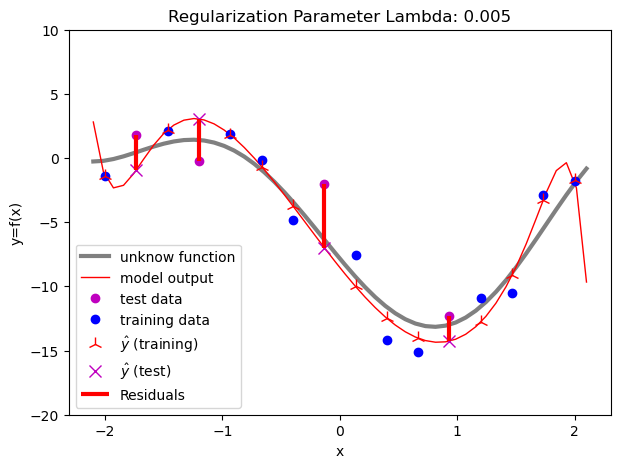

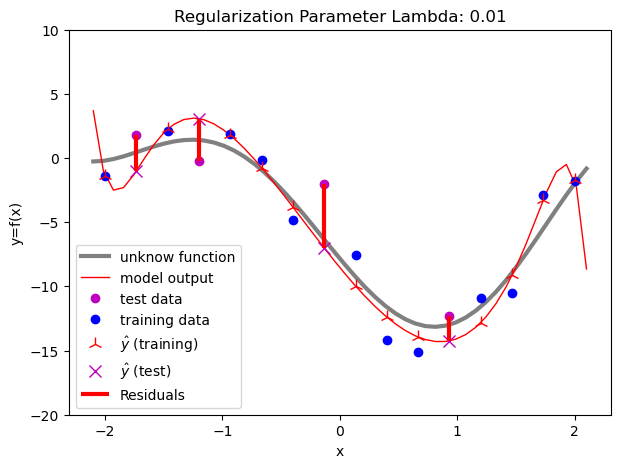

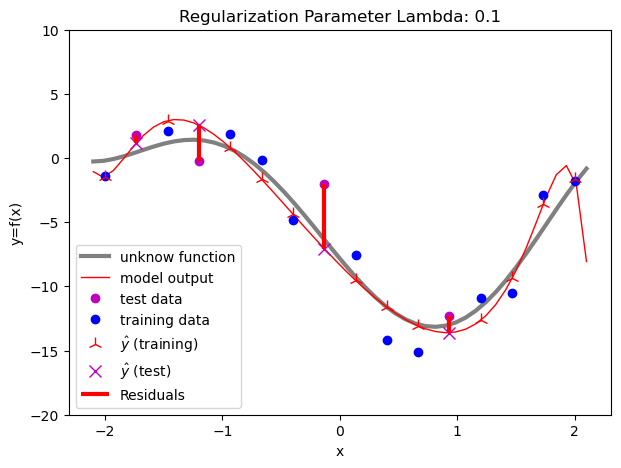

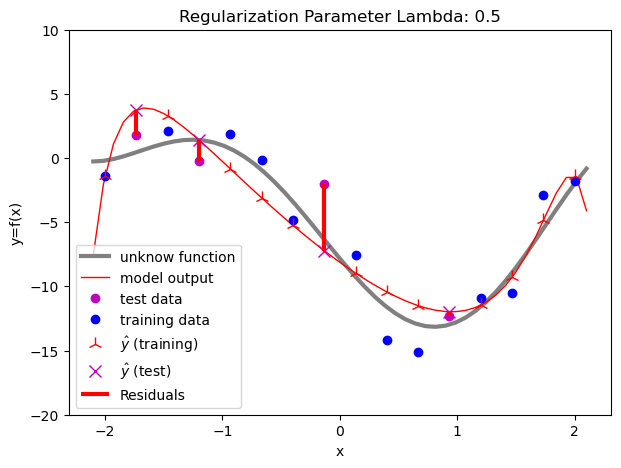

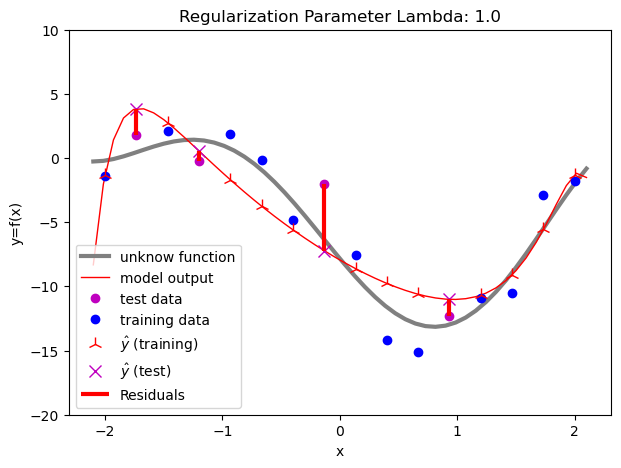

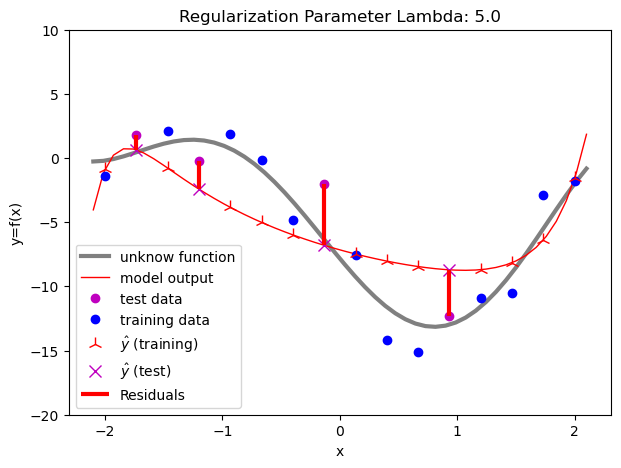

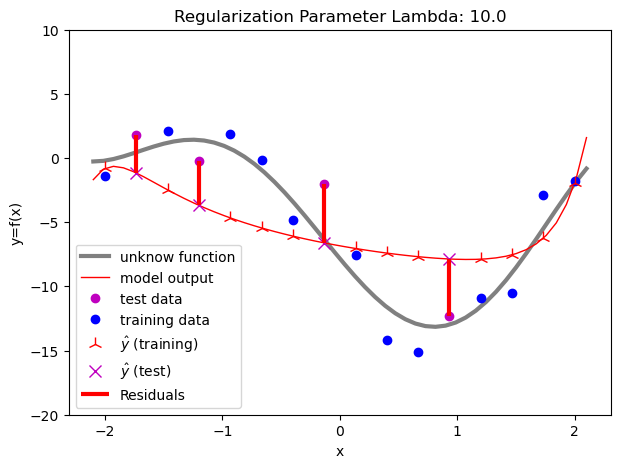

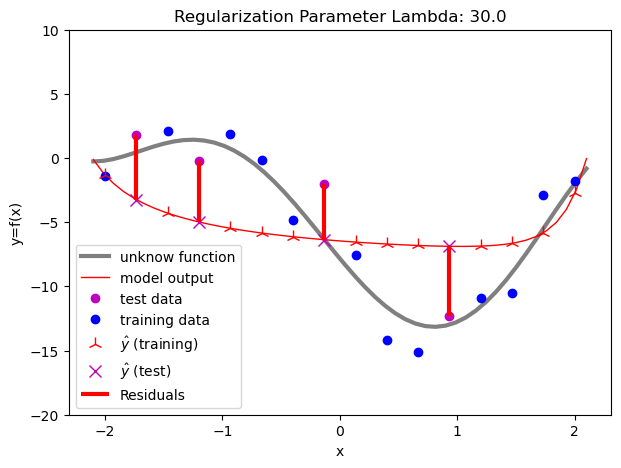

In [18]:
# Splitting into train and test set
X_train, X_test, Y_train, Y_test = split_train_test(X_Data, Y_Data, 0.3)


mse_history = {'mse_train': [],
               'mse_test': [],
               'l2_lambda': []}

l2_lambdas = [0.0, 0.00001, 0.0005, 0.001,
              0.005, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 30.0]

for l2_lambda in l2_lambdas:

    # Initialize the model with the current lambda
    model = linear_model.Ridge(alpha=l2_lambda)

    # Initialize the pipeline
    model_pipe = Pipeline([
        ("poly_ftr", poly_ftr),
        ("scaler", scaler),
        ("model", model)
    ])

    # Fit the model
    model_pipe.fit(X_train, Y_train)

    # Make a prediction
    y_hat_train = model_pipe.predict(X_train)
    y_hat_test = model_pipe.predict(X_test)
    
    # calculate the MSE
    mse_train = metrics.mean_squared_error(Y_train, y_hat_train)
    mse_test = metrics.mean_squared_error(Y_test, y_hat_test)

    # Append the results to the history
    mse_history['mse_train'].append(mse_train)
    mse_history['mse_test'].append(mse_test)
    mse_history['l2_lambda'].append(l2_lambda)

    # Plotting the Result
    plt.figure()
    plot_poly(coefficients, interval_plot_x)
    plot_model(model_pipe, interval_plot_x)
    plt.plot(X_test, Y_test, 'om', markersize=6, label='test data')
    plt.plot(X_train, Y_train, 'o', color='blue',
             markersize=6, label='training data')
    plt.plot(X_train, y_hat_train, '2r', markersize=10,
             label='$\hat{y}$ (training)')
    plt.plot(X_test, y_hat_test, 'xm', markersize=8,
             label='$\hat{y}$ (test)')
    # we can add the residuals by plotting vertical lines at the specified locations:
    # https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.vlines.html
    plt.vlines(X_test, Y_test, y_hat_test, colors='r',
               linewidth=3, label='Residuals')
    plt.ylim(interval_plot_y)
    plt.title(f'Regularization Parameter Lambda: {l2_lambda}')
    plt.legend()

    ###


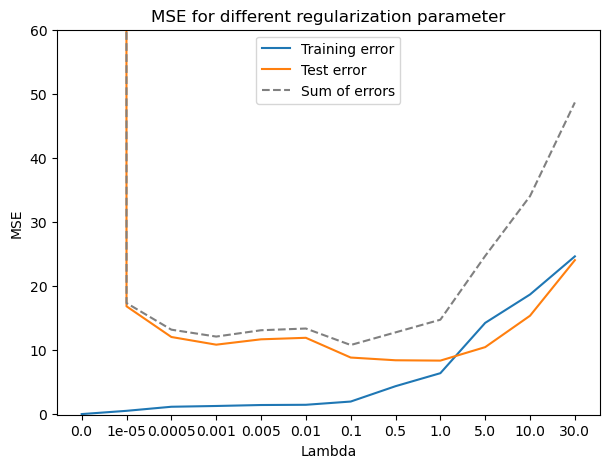

In [19]:
# Plotting the train and test error history
plt.figure()
plt.title('MSE for different regularization parameter')
plt.plot(mse_history['mse_train'], label='Training error')
plt.plot(mse_history['mse_test'], label='Test error')
error_sum = np.array(mse_history['mse_train']) + np.array(mse_history['mse_test'])
plt.plot(error_sum, label='Sum of errors', linestyle='--', color='gray')
plt.xlabel("Lambda")
plt.ylabel("MSE")
plt.ylim([-0.1, 60])
plt.xticks(np.arange(len(l2_lambdas)), l2_lambdas)
plt.legend()


As we can see above, lambda = 0 gives a low training error but a very high test error, indicating overfitting.

As we increase the value of lambda (reducing the complexity of the model) the test error starts to decrease but the training error starts to increase. 

After lambda = 0.1 we see that the training error starts to increase drastically and after lambda = 1 eventually the test error also starts to increase, indicating underfitting. 

One would choose a value of lambda between 0.1 and 1. 

At lambda=1 the training error increases significantly compared to the test error. The test error remains relatively stable from lambda 0.1 to lambda 1.